In [21]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Hàm làm sạch văn bản (giữ nguyên từ code của bạn)
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()  # Chuyển lowercase
    text = re.sub(r'[^\w\s]', ' ', text)  # Thay dấu câu bằng khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()  # Loại khoảng trắng thừa
    text = word_tokenize(text, format='text')  # Phân từ
    return text

In [23]:
train_df = pd.read_csv('/kaggle/input/cogdis-data/train_cleaned.csv', encoding='utf-8')
val_df = pd.read_csv('/kaggle/input/cogdis-data/val_cleaned.csv', encoding='utf-8')
test_df = pd.read_csv('/kaggle/input/cogdis-data/test_cleaned.csv', encoding='utf-8')

X_train = train_df['clean_text']
y_train = train_df['Label']
X_val = val_df['clean_text']
y_val = val_df['Label']
X_test = test_df['clean_text']
y_test = test_df['Label']

In [24]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Validation Results:
                precision    recall  f1-score   support

 No Distortion       0.60      0.83      0.70       506
Has Distortion       0.93      0.81      0.87      1503

      accuracy                           0.82      2009
     macro avg       0.77      0.82      0.78      2009
  weighted avg       0.85      0.82      0.83      2009

Validation Accuracy: 0.8178
Validation F1-Score: 0.8698


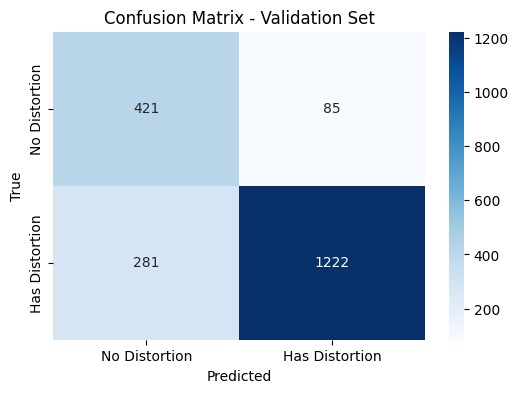

In [31]:
val_preds = model.predict(X_val_tfidf)
print("Validation Results:")
print(classification_report(y_val, val_preds, target_names=['No Distortion', 'Has Distortion']))
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds):.4f}")
print(f"Validation F1-Score: {f1_score(y_val, val_preds, average='binary'):.4f}")

cm_val = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['No Distortion', 'Has Distortion'], yticklabels=['No Distortion', 'Has Distortion'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Test Results:
                precision    recall  f1-score   support

 No Distortion       0.56      0.80      0.66       507
Has Distortion       0.92      0.78      0.85      1503

      accuracy                           0.79      2010
     macro avg       0.74      0.79      0.75      2010
  weighted avg       0.83      0.79      0.80      2010

Test Accuracy: 0.7886
Test F1-Score: 0.8472


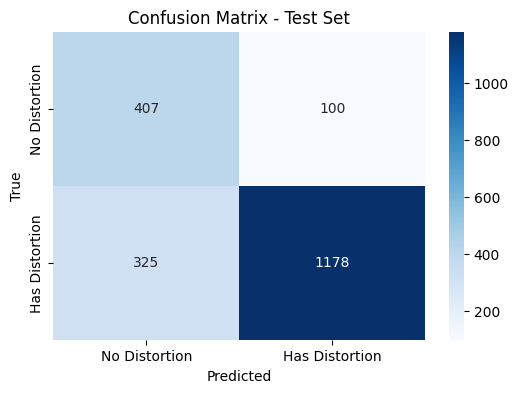

In [28]:
# Đánh giá trên tập test
test_preds = model.predict(X_test_tfidf)
print("\nTest Results:")
print(classification_report(y_test, test_preds, target_names=['No Distortion', 'Has Distortion']))
print(f"Test Accuracy: {accuracy_score(y_test, test_preds):.4f}")
print(f"Test F1-Score: {f1_score(y_test, test_preds, average='binary'):.4f}")

# Vẽ confusion matrix cho test
cm_test = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No Distortion', 'Has Distortion'], yticklabels=['No Distortion', 'Has Distortion'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
# Lưu mô hình và vectorizer
joblib.dump(model, '/kaggle/working/logistic_model.pkl')
joblib.dump(vectorizer, '/kaggle/working/tfidf_vectorizer.pkl')

['/kaggle/working/tfidf_vectorizer.pkl']